In [1]:
#
# phase1:
#   Gaussian Mixture Model (GMM) distribution approximating
#

%matplotlib inline
import os
os.environ['THEANO_FLAGS'] = "mode=FAST_RUN,device=cpu,floatX=float32"
import theano
import theano.tensor as T
import config
import numpy as np
import matplotlib.pyplot as plt

/Library/Python/2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import network
import network.normFlow as nf
import utils
import utils.mathT as mathT
import utils.mathZ as mathZ
import utils.theanoGeneral as utilsT
import utils.optimizers as optimizers
import utils.plotZ as plotZ
import seaborn as sns

:0: FutureWarning: IPython widgets are experimental and may change in the future.


8
9


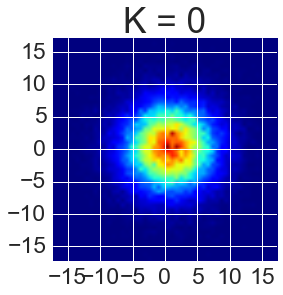

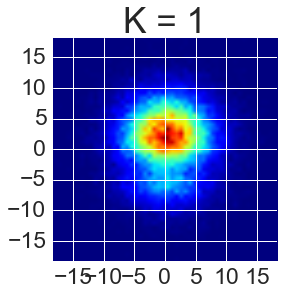

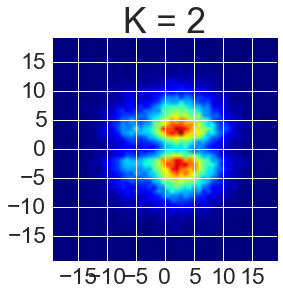

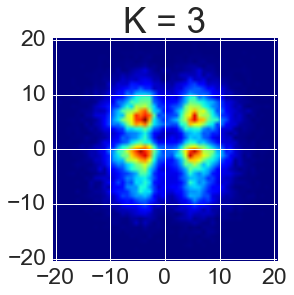

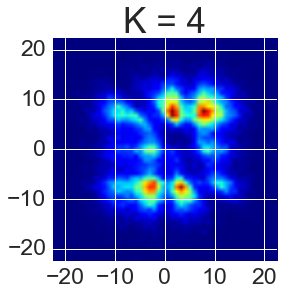

In [21]:
###
### PLOT BY LAYERS, RAND-INITIALISATION
###

PRENUM = 50000
NUM_LAYERS = 4
Z0_TYPE, STD = 'normal',4
# Z0_TYPE, STD = 'uniform', 30


# construction variational model
scale_list = list( np.arange(1.2,1.8,.6/NUM_LAYERS) )
iaf = nf.NormFlowModel( dim=2, numlayers=NUM_LAYERS, noisestd=STD, z0type=Z0_TYPE, scalelst=scale_list )

print len(iaf.layers )
iaf.layers[0].setParamValues( {'w':np.asarray([[0.8,0],[0,0]]),   'u':np.ones(2),  'b':np.asarray([3,0])} )
iaf.layers[2].setParamValues( {'w':np.asarray([[2,0],[0,0]]),   'u':np.ones(2),  'b':np.asarray([0,-3])} )
iaf.layers[4].setParamValues( {'w':np.asarray([[2,0],[0,1]]),   'u':np.ones(2)*1.2,  'b':np.asarray([-1,-1])} )
iaf.layers[6].setParamValues( {'w':np.asarray([[2,2],[0,2]]),   'u':np.ones(2)*2,  'b':np.asarray([7,0])} )

es = iaf.getNoiseVar(PRENUM)
zs, logqzs = iaf.reparam(es,inter=True)
print len(zs)

# for presentation
# fezs = theano.function(inputs=[],outputs=[ zs[0],zs[2],zs[4],zs[8],zs[10],zs[12],zs[14],zs[16],zs[32] ] )
fezs = theano.function(inputs=[],outputs=[ zs[0],zs[2],zs[4],zs[6],zs[8] ] )

# LAYERS = ['z0','1','2','4','5','6','7','8','16']
LAYERS = ['0','1','2','3','4']
FIG_PATH = '../report/figs/bylayers/'+Z0_TYPE
ezs = fezs()
xlims = (-4.,+4.)
ylims = (-4.,+4.)
for l, L in enumerate(LAYERS):    
    zzz = ezs[l]
    heatmap, xedges, yedges = np.histogram2d( zzz[:,0], zzz[:,1], bins=50)
#     extent = [xlims[0], xlims[1], ylims[0], ylims[1]]
    ext = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    MAG = max(np.abs(np.asarray(ext)))
    plt.figure()
    plt.imshow(heatmap.T, extent=[-MAG,MAG,-MAG,MAG], origin='lower',cmap='jet')
    plt.axes().set_aspect('equal')
    plt.title('K = %s' % (L), fontsize=35)
    plt.tick_params(axis='both', which='major', labelsize=23)
    if SAVE_FLAG:
        plt.savefig( FIG_PATH+'/K%s.png'%(L))

In [126]:
###
### Evolution
###

# parameter setup
DIM = 2
SAMPLINGNUM = 20
floatX = utils.floatX


# model
NUM_LAYERS = 32
# Z0_TYPE,STD = 'uniform',5  
Z0_TYPE, STD = 'normal',2.3
SAVE_FLAG = True

# /gmm
# FIG_PATH = '../report/figs/gmm/'+Z0_TYPE
# means   = np.asarray( [[1.0,2.0],[-0.,-2.5],[-2.0,1.0]] )
# varmats = np.asarray( [np.eye(2)/2, np.eye(2)/3, np.eye(2)/4] ) 
# weights = np.asarray( [0.4,0.3,0.3] )
# NUMITER = 10000
# ziters = [0,19,49,99,199,999,1999,4999,NUMITER-1]


# /complexity
FIG_PATH = '../report/figs/complexity'
means   = np.asarray( [[0.6,2.0],   [2.0,-2.5],  [-1.5,-2], [-2.0,1.0], [0.5,0] ] )
varmats = np.asarray( [np.eye(2)/4, np.eye(2)/4, np.eye(2)/3, np.eye(2)/4, np.eye(2)/5 ] ) 
weights = np.asarray( [0.2, 0.2, 0.2, 0.3, 0.1] )
NUMITER = 10000
ziters = [NUMITER-1]

logTarget = mathT.multiGmm(means, varmats,weights)


In [114]:
# construction variational model
iaf = nf.NormFlowModel( dim=2, numlayers=NUM_LAYERS, noisestd=STD, z0type=Z0_TYPE )  #(4./DIM)**.5
e = iaf.getNoiseVar(SAMPLINGNUM)
z, logqz = iaf.reparam(e)

# setting cost variable
logpz = logTarget(z)
cost = T.mean( logqz - logpz ) # KL cost

params = iaf.getParams()
grads = [ T.grad(cost,p,consider_constant=[e]) for p in params ]

In [115]:
# optimisation setup
iaf.reInit()
opt = optimizers.SGD(params,lr=0.05,momentum=0.5,decay=0.001)
updates = opt.getUpdates(params,grads)

outputs = [ cost, T.mean(logpz), T.mean(logqz) ]
estep = theano.function(inputs=[],outputs=outputs,updates=updates)

In [116]:
# for presentation
e2 = iaf.getNoiseVar(50000)
z2, logqz2 = iaf.reparam(e2)
fez2 = theano.function(inputs=[],outputs=[e2,z2])
# training
keys = ['cost','pz','qz']
record = {'zs':[]}

for k in keys:
    record[k] = []
    
zset = set(ziters)
for i in range(NUMITER):
    out = estep()
    for k,q in enumerate(out):
        record[keys[k]].append( q )
    if i in zset:
        print 'samples of iter %d'%i
        record['zs'].append(fez2()[1])
        
for k in keys:
    record[k] = np.asarray( record[k] )

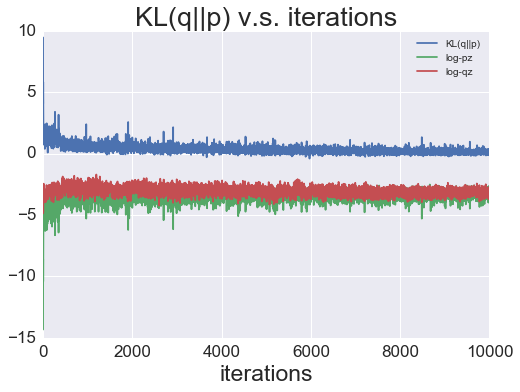

In [127]:
###
### KL-divergence
###

xs = range(NUMITER)
plt.plot( xs, record['cost'], '-', label='KL(q||p)')
plt.xlabel('iterations',fontsize=23)
plt.title('KL(q||p) v.s. iterations',fontsize=27)
plt.tick_params(axis='both', which='major', labelsize=17)
if SAVE_FLAG:
    plt.savefig(FIG_PATH+'/L%d_kl.png'%(NUM_LAYERS))
plt.plot( xs, record['pz'], '-', label='log-pz')
plt.plot( xs, record['qz'], '-', label='log-qz')
plt.legend()

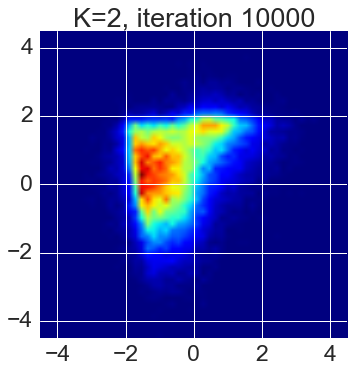

In [143]:
###
### PLOTTING Q(Z)
###

LID = 2
# LID = NUM_LAYERS
record = np.load( '../report/figs/complexity/record_L%d.npz'%(LID) )
ziters = record['iters']

xlims = (-4.5,+4.5)
ylims = (-4.5,+4.5)
for idz, iditer in enumerate(ziters):
    zzz = record['zs'][idz]    
    heatmap, xedges, yedges = np.histogram2d( zzz[:,0], zzz[:,1], bins=50)
    extent = [xlims[0], xlims[1], ylims[0], ylims[1]]
    plt.figure()
    plt.imshow(heatmap.T, extent=extent, origin='lower', cmap='jet')
    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.title('K=%d, iteration %d' % (LID,iditer+1), fontsize=27)
    plt.tick_params(axis='both', which='major', labelsize=23)
    if SAVE_FLAG:
        plt.savefig( FIG_PATH+'/evolve/L%d_iter%d'%(LID,iditer+1))

In [129]:
###
### SAVING RECORD
###
SAVEPATH = FIG_PATH+'/record_L%d.npz'%NUM_LAYERS
np.savez(SAVEPATH,cost=record['cost'],zs=record['zs'],numiter=NUMITER,iters=ziters,numlayers=NUM_LAYERS)
print 'record saved to %s' % SAVEPATH

record saved to ../report/figs/complexity/record_L32.npz


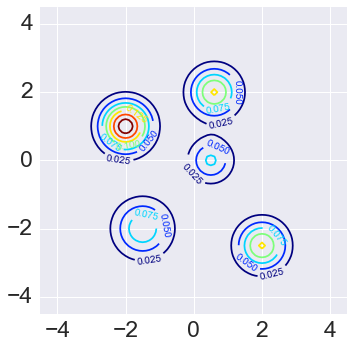

saved to ../report/figs/complexity/gmm.png


In [145]:
###
### TRUE P(Z)
###
SAVEPATH = FIG_PATH+'/gmm.png'
fgmm = mathZ.multiGmmInit(means,varmats,weights)
showvalues = []
gz, g1, g2 = mathZ.gridPoints( (-5,5,0.1), (-5,5,0.1) )
gpz = np.exp( fgmm(gz).reshape(g1.shape[1],g2.shape[0]) )
fig = plt.figure()
CS = plt.contour(g1,g2,gpz,cmap='jet')
plt.clabel(CS, inline=1, fontsize=10)
plt.xlim(xlims)
plt.ylim(ylims)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.axes().set_aspect('equal')
if SAVE_FLAG:
    plt.savefig(SAVEPATH)
plt.show()
print 'saved to %s' % SAVEPATH

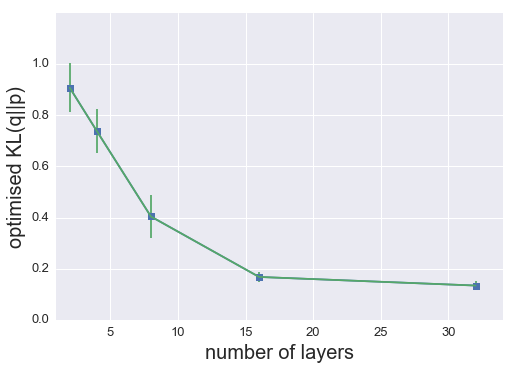

In [148]:
###
### COMPLEXITY, comparing KL-div
###

NUM_LS = [2,4,8,16,32]
rs = list()
costs = list()
for i, L in enumerate(NUM_LS):
    rs.append(  np.load(FIG_PATH+'/record_L%d.npz'%L) )
    costs.append( rs[-1]['cost'][9500:] )
costs = np.asarray( costs )
bars = [ np.var(costs[i]) for i in range(len(NUM_LS)) ]
costs = np.mean(costs,axis=1)

plt.plot( NUM_LS, costs, '-s')
plt.errorbar(NUM_LS,costs,yerr=bars)
plt.xlabel('number of layers',fontsize=20)
plt.ylabel('optimised KL(q||p)',fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=17)
plt.xlim([1,NUM_LS[-1]+2])
plt.ylim([0,1.2])
plt.tick_params(axis='both', which='major', labelsize=13)
if SAVE_FLAG:
    plt.savefig(FIG_PATH+'/KLvsL.png')

In [136]:
print rs[0].keys()

['iters', 'cost', 'numiter', 'numlayers', 'zs']
